In [1]:
#%cd C:/Users/Mathieu/Desktop/Projets/Benter
%cd /home/mathieu/Mindsay/mathieu/Benter-Project

/home/mathieu/Mindsay/mathieu/Benter-Project


In [2]:
%matplotlib inline
import collections
import functools

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
from tqdm import tqdm


from utils import import_data
from winning_horse_models.logistic_regression import LogisticRegressionModel
from constants import PMU_BETTINGS, SOURCE_PMU
from utils.wagering_stategy import compute_expected_return, compute_scenario, plot_scenario, plot_expected_return
import wagering_stategies

from wagering_stategies import factories as wagering_factories

from matplotlib import style
style.use('ggplot')

In [3]:
winning_model = LogisticRegressionModel.load_model(trainable=False)

In [4]:
for compute_betting_fun in [wagering_stategies.race_betting_best_expected_return, 
                            wagering_stategies.race_betting_best_winning_proba,
                           wagering_stategies.race_betting_best_winning_proba_not_max_pari_mutual_proba,
                           wagering_stategies.race_betting_proportional_positive_return,
                           wagering_stategies.race_betting_proportional_winning_proba,
                           wagering_stategies.race_bettings_kelly,
                           wagering_stategies.race_least_risky_horse,
                           wagering_stategies.race_proportional_odds,
                           wagering_stategies.race_proportional_pari_mutual_proba,
                           wagering_stategies.race_random_all_horses,
                           wagering_stategies.race_random_one_horse,
                           wagering_stategies.race_rickiest_horse]:
    print(compute_betting_fun.__name__)
    e_r_df = compute_expected_return(
                    compute_betting_fun=wagering_stategies.race_random_one_horse,
                    source=SOURCE_PMU,
                    code_pari="E_SIMPLE_GAGNANT",
                    winning_model=winning_model,
                ) 
    plot_expected_return(expected_return_df=e_r_df)
    print()

race_betting_best_expected_return


On all races, your expected return is -27.72% (std: 3.4)
You bet 100.00% of the time (11929 out of 11929 races)
No races without bettings!
When you bet, on average your expected return is -27.72% (std: 3.4)
When you bet, you win 9.80% of the time (1169 out of 11929 bets)
When you bet, you lose 90.20% of the time(10760 out of 11929 bets)
When you bet&win, you make +637.60% (std: 8.3)
While betting, Average losing streaks 10.237868696479543 (std: 9.8)
While betting, Longest losing streak: 71
While betting, Longest winning streak: 4

race_betting_best_winning_proba


On all races, your expected return is -27.23% (std: 3.5)
You bet 100.00% of the time (11929 out of 11929 races)
No races without bettings!
When you bet, on average your expected return is -27.23% (std: 3.5)
When you bet, you win 9.57% of the time (1142 out of 11929 bets)
When you bet, you lose 90.43% of the time(10787 out of 11929 bets)
When you bet&win, you make +660.09% (std: 8.7)
While betting, Average losing streaks 10.596267190569744 (std: 10.3)
While betting, Longest losing streak: 75
While betting, Longest winning streak: 4

race_betting_best_winning_proba_not_max_pari_mutual_proba


On all races, your expected return is -27.69% (std: 3.7)
You bet 100.00% of the time (11929 out of 11929 races)
No races without bettings!
When you bet, on average your expected return is -27.69% (std: 3.7)
When you bet, you win 9.67% of the time (1154 out of 11929 bets)
When you bet, you lose 90.33% of the time(10775 out of 11929 bets)
When you bet&win, you make +647.53% (std: 9.4)
While betting, Average losing streaks 10.350624399615754 (std: 10.0)
While betting, Longest losing streak: 84
While betting, Longest winning streak: 3

race_betting_proportional_positive_return


On all races, your expected return is -32.45% (std: 3.4)
You bet 100.00% of the time (11929 out of 11929 races)
No races without bettings!
When you bet, on average your expected return is -32.45% (std: 3.4)
When you bet, you win 8.93% of the time (1065 out of 11929 bets)
When you bet, you lose 91.07% of the time(10864 out of 11929 bets)
When you bet&win, you make +656.61% (std: 8.6)
While betting, Average losing streaks 11.085714285714285 (std: 11.5)
While betting, Longest losing streak: 100
While betting, Longest winning streak: 4

race_betting_proportional_winning_proba


On all races, your expected return is -24.07% (std: 3.7)
You bet 100.00% of the time (11929 out of 11929 races)
No races without bettings!
When you bet, on average your expected return is -24.07% (std: 3.7)
When you bet, you win 9.76% of the time (1164 out of 11929 bets)
When you bet, you lose 90.24% of the time(10765 out of 11929 bets)
When you bet&win, you make +678.02% (std: 9.4)
While betting, Average losing streaks 10.242626070409134 (std: 9.8)
While betting, Longest losing streak: 68
While betting, Longest winning streak: 4

race_bettings_kelly


On all races, your expected return is -24.84% (std: 3.9)
You bet 100.00% of the time (11929 out of 11929 races)
No races without bettings!
When you bet, on average your expected return is -24.84% (std: 3.9)
When you bet, you win 9.89% of the time (1180 out of 11929 bets)
When you bet, you lose 90.11% of the time(10749 out of 11929 bets)
When you bet&win, you make +659.61% (std: 10.1)
While betting, Average losing streaks 10.159735349716446 (std: 9.1)
While betting, Longest losing streak: 57
While betting, Longest winning streak: 3

race_least_risky_horse


On all races, your expected return is -20.75% (std: 4.0)
You bet 100.00% of the time (11929 out of 11929 races)
No races without bettings!
When you bet, on average your expected return is -20.75% (std: 4.0)
When you bet, you win 9.88% of the time (1178 out of 11929 bets)
When you bet, you lose 90.12% of the time(10751 out of 11929 bets)
When you bet&win, you make +702.45% (std: 10.2)
While betting, Average losing streaks 10.152030217186024 (std: 9.2)
While betting, Longest losing streak: 70
While betting, Longest winning streak: 4

race_proportional_odds


On all races, your expected return is -23.71% (std: 4.0)
You bet 100.00% of the time (11929 out of 11929 races)
No races without bettings!
When you bet, on average your expected return is -23.71% (std: 4.0)
When you bet, you win 9.69% of the time (1156 out of 11929 bets)
When you bet, you lose 90.31% of the time(10773 out of 11929 bets)
When you bet&win, you make +687.12% (std: 10.4)
While betting, Average losing streaks 10.348703170028818 (std: 9.7)
While betting, Longest losing streak: 67
While betting, Longest winning streak: 4

race_proportional_pari_mutual_proba


On all races, your expected return is -25.79% (std: 3.8)
You bet 100.00% of the time (11929 out of 11929 races)
No races without bettings!
When you bet, on average your expected return is -25.79% (std: 3.8)
When you bet, you win 9.33% of the time (1113 out of 11929 bets)
When you bet, you lose 90.67% of the time(10816 out of 11929 bets)
When you bet&win, you make +695.38% (std: 10.0)
While betting, Average losing streaks 10.772908366533864 (std: 10.2)
While betting, Longest losing streak: 72
While betting, Longest winning streak: 3

race_random_all_horses


On all races, your expected return is -23.10% (std: 4.4)
You bet 100.00% of the time (11929 out of 11929 races)
No races without bettings!
When you bet, on average your expected return is -23.10% (std: 4.4)
When you bet, you win 9.25% of the time (1104 out of 11929 bets)
When you bet, you lose 90.75% of the time(10825 out of 11929 bets)
When you bet&win, you make +730.71% (std: 12.3)
While betting, Average losing streaks 10.890342052313883 (std: 10.9)
While betting, Longest losing streak: 95
While betting, Longest winning streak: 5

race_random_one_horse


On all races, your expected return is -25.03% (std: 3.7)
You bet 100.00% of the time (11929 out of 11929 races)
No races without bettings!
When you bet, on average your expected return is -25.03% (std: 3.7)
When you bet, you win 9.62% of the time (1147 out of 11929 bets)
When you bet, you lose 90.38% of the time(10782 out of 11929 bets)
When you bet&win, you make +679.55% (std: 9.5)
While betting, Average losing streaks 10.307839388145316 (std: 10.3)
While betting, Longest losing streak: 89
While betting, Longest winning streak: 3

race_rickiest_horse


On all races, your expected return is -22.72% (std: 3.9)
You bet 100.00% of the time (11929 out of 11929 races)
No races without bettings!
When you bet, on average your expected return is -22.72% (std: 3.9)
When you bet, you win 9.67% of the time (1153 out of 11929 bets)
When you bet, you lose 90.33% of the time(10776 out of 11929 bets)
When you bet&win, you make +699.59% (std: 9.9)
While betting, Average losing streaks 10.421663442940039 (std: 9.9)
While betting, Longest losing streak: 70
While betting, Longest winning streak: 4



In [4]:
%%time
res={}
for minimum_winning_proba in np.arange(0.0, 0.51, 0.1):
    for minimum_expected_return in np.arange(0.0, 16.1, 2):
        e_r_df = compute_expected_return(
                    compute_betting_fun=wagering_factories.betting_on_best_exp_return_thresholded_winning_proba_expected_returns_factory(minimum_winning_probabilities=minimum_winning_proba, 
                                                                                                                                                      expected_return_threshold=minimum_expected_return),
                    source=SOURCE_PMU,
                    code_pari="E_SIMPLE_GAGNANT",
                    winning_model=winning_model,
                ) 
        print(minimum_winning_proba, minimum_expected_return, e_r_df.relative_expected_return.mean(),e_r_df.relative_expected_return.std())
        res[(minimum_winning_proba,minimum_expected_return)]={'mean':e_r_df.relative_expected_return.mean(), 'std':e_r_df.relative_expected_return.std()}
        plot_expected_return(expected_return_df=e_r_df)
        print()

/home/mathieu/Mindsay/mathieu/Benter-Project/utils/import_data.py:241: DtypeWarning: Columns (35,46,47,61,62,63,64,87) have mixed types.Specify dtype option on import or set low_memory=False.
  rh_df = get_split_date(source=source, on_split=on_split)
/home/mathieu/.pyenv/versions/3.7.4/envs/venv_benter/lib/python3.7/site-packages/pandas-1.0.4-py3.7-linux-x86_64.egg/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/home/mathieu/Mindsay/mathieu/Benter-Project/utils/preprocess.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

0.0 0.0 -0.32638551439325775 5.6022941252244
On all races, your expected return is -32.64% (std: 5.6)
You bet 100.00% of the time (11929 out of 11929 races)
No races without bettings!
When you bet, on average your expected return is -32.64% (std: 5.6)
When you bet, you win 3.78% of the time (451 out of 11929 bets)
When you bet, you lose 96.22% of the time(11478 out of 11929 bets)
When you bet&win, you make +1681.72% (std: 22.9)
While betting, Average losing streaks 26.63109048723898 (std: 31.6)
While betting, Longest losing streak: 226
While betting, Longest winning streak: 3



  0%|          | 0/11929 [00:00<?, ?it/s]/home/mathieu/Mindsay/mathieu/Benter-Project/utils/wagering_stategy.py:83: RuntimeWarning: invalid value encountered in double_scalars
  relative_expected_return = expected_return / np.sum(actual_betting)


0.0 2.0 -0.32875729174917107 6.19902028906792
On all races, your expected return is -32.88% (std: 6.2)
You bet 69.60% of the time (8303 out of 11929 races)
Average not betting streaks: 1.66 races
When you bet, on average your expected return is -32.88% (std: 6.2)
When you bet, you win 2.04% of the time (169 out of 8303 bets)
When you bet, you lose 97.96% of the time(8134 out of 8303 bets)
When you bet&win, you make +3197.83% (std: 28.8)
While betting, Average losing streaks 49.2969696969697 (std: 61.6)
While betting, Longest losing streak: 465
While betting, Longest winning streak: 2



0.0 4.0 -0.5289556040885965 5.414322406168128
On all races, your expected return is -52.90% (std: 5.4)
You bet 31.70% of the time (3781 out of 11929 races)
Average not betting streaks: 3.63 races
When you bet, on average your expected return is -52.90% (std: 5.4)
When you bet, you win 1.08% of the time (41 out of 3781 bets)
When you bet, you lose 98.92% of the time(3740 out of 3781 bets)
When you bet&win, you make +4243.95% (std: 29.3)
While betting, Average losing streaks 91.21951219512195 (std: 101.1)
While betting, Longest losing streak: 435
While betting, Longest winning streak: 2



0.0 6.0 -0.6229423626271504 5.473315911421565
On all races, your expected return is -62.29% (std: 5.5)
You bet 14.23% of the time (1698 out of 11929 races)
Average not betting streaks: 7.85 races
When you bet, on average your expected return is -62.29% (std: 5.5)
When you bet, you win 0.65% of the time (11 out of 1698 bets)
When you bet, you lose 99.35% of the time(1687 out of 1698 bets)
When you bet&win, you make +5720.40% (std: 37.2)
While betting, Average losing streaks 140.58333333333334 (std: 171.0)
While betting, Longest losing streak: 490
While betting, Longest winning streak: 1



0.0 8.0 -0.6386152340785207 5.339556925484524
On all races, your expected return is -63.86% (std: 5.3)
You bet 6.61% of the time (788 out of 11929 races)
Average not betting streaks: 16.31 races
When you bet, on average your expected return is -63.86% (std: 5.3)
When you bet, you win 0.51% of the time (4 out of 788 bets)
When you bet, you lose 99.49% of the time(784 out of 788 bets)
When you bet&win, you make +7019.28% (std: 27.5)
While betting, Average losing streaks 156.8 (std: 72.8)
While betting, Longest losing streak: 261
While betting, Longest winning streak: 1



0.0 10.0 -0.48314402283867425 6.4156391271650595
On all races, your expected return is -48.31% (std: 6.4)
You bet 3.37% of the time (402 out of 11929 races)
Average not betting streaks: 31.24 races
When you bet, on average your expected return is -48.31% (std: 6.4)
When you bet, you win 0.75% of the time (3 out of 402 bets)
When you bet, you lose 99.25% of the time(399 out of 402 bets)
When you bet&win, you make +6825.87% (std: 33.3)
While betting, Average losing streaks 99.75 (std: 54.1)
While betting, Longest losing streak: 162
While betting, Longest winning streak: 1



0.0 12.0 -1.0 0.0
On all races, your expected return is -100.00% (std: 0.0)
You bet 1.94% of the time (231 out of 11929 races)
Average not betting streaks: 53.91 races
When you bet, on average your expected return is -100.00% (std: 0.0)
When you bet, you win 0.00% of the time (0 out of 231 bets)
When you bet, you lose 100.00% of the time(231 out of 231 bets)
Not winning any bets!
While betting, Average losing streaks 231.0 (std: 0.0)
While betting, Longest losing streak: 231
There is no winning streaks!



0.0 14.0 -1.0 0.0
On all races, your expected return is -100.00% (std: 0.0)
You bet 1.23% of the time (147 out of 11929 races)
Average not betting streaks: 86.00 races
When you bet, on average your expected return is -100.00% (std: 0.0)
When you bet, you win 0.00% of the time (0 out of 147 bets)
When you bet, you lose 100.00% of the time(147 out of 147 bets)
Not winning any bets!
While betting, Average losing streaks 147.0 (std: 0.0)
While betting, Longest losing streak: 147
There is no winning streaks!



0.0 16.0 -1.0 0.0
On all races, your expected return is -100.00% (std: 0.0)
You bet 0.90% of the time (107 out of 11929 races)
Average not betting streaks: 118.22 races
When you bet, on average your expected return is -100.00% (std: 0.0)
When you bet, you win 0.00% of the time (0 out of 107 bets)
When you bet, you lose 100.00% of the time(107 out of 107 bets)
Not winning any bets!
While betting, Average losing streaks 107.0 (std: 0.0)
While betting, Longest losing streak: 107
There is no winning streaks!



0.1 0.0 -0.14476776457239426 3.551169395005771
On all races, your expected return is -14.48% (std: 3.6)
You bet 95.79% of the time (11427 out of 11929 races)
Average not betting streaks: 1.08 races
When you bet, on average your expected return is -14.48% (std: 3.6)
When you bet, you win 10.70% of the time (1223 out of 11427 bets)
When you bet, you lose 89.30% of the time(10204 out of 11427 bets)
When you bet&win, you make +699.00% (std: 7.8)
While betting, Average losing streaks 9.395948434622468 (std: 9.6)
While betting, Longest losing streak: 79
While betting, Longest winning streak: 4



0.1 2.0 -0.1649706465207029 4.829604277966169
On all races, your expected return is -16.50% (std: 4.8)
You bet 29.60% of the time (3531 out of 11929 races)
Average not betting streaks: 3.57 races
When you bet, on average your expected return is -16.50% (std: 4.8)
When you bet, you win 4.36% of the time (154 out of 3531 bets)
When you bet, you lose 95.64% of the time(3377 out of 3531 bets)
When you bet&win, you make +1814.60% (std: 13.6)
While betting, Average losing streaks 22.664429530201343 (std: 27.7)
While betting, Longest losing streak: 207
While betting, Longest winning streak: 3



0.1 4.0 -0.26258227366233855 5.6637792138996526
On all races, your expected return is -26.26% (std: 5.7)
You bet 10.22% of the time (1219 out of 11929 races)
Average not betting streaks: 10.22 races
When you bet, on average your expected return is -26.26% (std: 5.7)
When you bet, you win 2.54% of the time (31 out of 1219 bets)
When you bet, you lose 97.46% of the time(1188 out of 1219 bets)
When you bet&win, you make +2799.72% (std: 21.3)
While betting, Average losing streaks 38.32258064516129 (std: 43.1)
While betting, Longest losing streak: 167
While betting, Longest winning streak: 2



0.1 6.0 -0.5577390105100801 5.599919455592851
On all races, your expected return is -55.77% (std: 5.6)
You bet 4.50% of the time (537 out of 11929 races)
Average not betting streaks: 23.44 races
When you bet, on average your expected return is -55.77% (std: 5.6)
When you bet, you win 1.12% of the time (6 out of 537 bets)
When you bet, you lose 98.88% of the time(531 out of 537 bets)
When you bet&win, you make +3858.24% (std: 38.8)
While betting, Average losing streaks 75.85714285714286 (std: 61.3)
While betting, Longest losing streak: 175
While betting, Longest winning streak: 1



0.1 8.0 -0.21296930750434478 7.908505970911784
On all races, your expected return is -21.30% (std: 7.9)
You bet 2.21% of the time (264 out of 11929 races)
Average not betting streaks: 46.29 races
When you bet, on average your expected return is -21.30% (std: 7.9)
When you bet, you win 1.14% of the time (3 out of 264 bets)
When you bet, you lose 98.86% of the time(261 out of 264 bets)
When you bet&win, you make +6825.87% (std: 33.3)
While betting, Average losing streaks 65.25 (std: 29.3)
While betting, Longest losing streak: 104
While betting, Longest winning streak: 1



0.1 10.0 0.42312399190995187 10.608074268086831
On all races, your expected return is +42.31% (std: 10.6)
You bet 1.22% of the time (146 out of 11929 races)
Average not betting streaks: 82.98 races
When you bet, on average your expected return is +42.31% (std: 10.6)
When you bet, you win 2.05% of the time (3 out of 146 bets)
When you bet, you lose 97.95% of the time(143 out of 146 bets)
When you bet&win, you make +6825.87% (std: 33.3)
While betting, Average losing streaks 35.75 (std: 17.6)
While betting, Longest losing streak: 58
While betting, Longest winning streak: 1



0.1 12.0 -1.0 0.0
On all races, your expected return is -100.00% (std: 0.0)
You bet 0.75% of the time (89 out of 11929 races)
Average not betting streaks: 133.03 races
When you bet, on average your expected return is -100.00% (std: 0.0)
When you bet, you win 0.00% of the time (0 out of 89 bets)
When you bet, you lose 100.00% of the time(89 out of 89 bets)
Not winning any bets!
While betting, Average losing streaks 89.0 (std: 0.0)
While betting, Longest losing streak: 89
There is no winning streaks!



0.1 14.0 -1.0 0.0
On all races, your expected return is -100.00% (std: 0.0)
You bet 0.41% of the time (49 out of 11929 races)
Average not betting streaks: 242.45 races
When you bet, on average your expected return is -100.00% (std: 0.0)
When you bet, you win 0.00% of the time (0 out of 49 bets)
When you bet, you lose 100.00% of the time(49 out of 49 bets)
Not winning any bets!
While betting, Average losing streaks 49.0 (std: 0.0)
While betting, Longest losing streak: 49
There is no winning streaks!



0.1 16.0 -1.0 0.0
On all races, your expected return is -100.00% (std: 0.0)
You bet 0.31% of the time (37 out of 11929 races)
Average not betting streaks: 312.95 races
When you bet, on average your expected return is -100.00% (std: 0.0)
When you bet, you win 0.00% of the time (0 out of 37 bets)
When you bet, you lose 100.00% of the time(37 out of 37 bets)
Not winning any bets!
While betting, Average losing streaks 37.0 (std: 0.0)
While betting, Longest losing streak: 37
There is no winning streaks!



0.2 0.0 -0.12177763293197418 2.1366343995021433
On all races, your expected return is -12.18% (std: 2.1)
You bet 51.89% of the time (6190 out of 11929 races)
Average not betting streaks: 2.08 races
When you bet, on average your expected return is -12.18% (std: 2.1)
When you bet, you win 22.34% of the time (1383 out of 6190 bets)
When you bet, you lose 77.66% of the time(4807 out of 6190 bets)
When you bet&win, you make +292.93% (std: 2.9)
While betting, Average losing streaks 4.471627906976744 (std: 3.9)
While betting, Longest losing streak: 30
While betting, Longest winning streak: 6



0.2 2.0 -0.128653351718932 3.388058662093092
On all races, your expected return is -12.87% (std: 3.4)
You bet 7.83% of the time (934 out of 11929 races)
Average not betting streaks: 13.20 races
When you bet, on average your expected return is -12.87% (std: 3.4)
When you bet, you win 7.92% of the time (74 out of 934 bets)
When you bet, you lose 92.08% of the time(860 out of 934 bets)
When you bet&win, you make +999.78% (std: 5.8)
While betting, Average losing streaks 13.65079365079365 (std: 14.2)
While betting, Longest losing streak: 77
While betting, Longest winning streak: 2



0.2 4.0 -0.18903347059030748 3.9350846069604413
On all races, your expected return is -18.90% (std: 3.9)
You bet 2.26% of the time (270 out of 11929 races)
Average not betting streaks: 45.19 races
When you bet, on average your expected return is -18.90% (std: 3.9)
When you bet, you win 5.19% of the time (14 out of 270 bets)
When you bet, you lose 94.81% of the time(256 out of 270 bets)
When you bet&win, you make +1464.01% (std: 8.4)
While betting, Average losing streaks 19.692307692307693 (std: 23.8)
While betting, Longest losing streak: 72
While betting, Longest winning streak: 2



0.2 6.0 -0.5710832194757335 3.205364956540813
On all races, your expected return is -57.11% (std: 3.2)
You bet 1.06% of the time (126 out of 11929 races)
Average not betting streaks: 95.96 races
When you bet, on average your expected return is -57.11% (std: 3.2)
When you bet, you win 2.38% of the time (3 out of 126 bets)
When you bet, you lose 97.62% of the time(123 out of 126 bets)
When you bet&win, you make +1701.45% (std: 12.9)
While betting, Average losing streaks 30.75 (std: 26.5)
While betting, Longest losing streak: 71
While betting, Longest winning streak: 1



0.2 8.0 -0.46139758919961427 4.206619304396256
On all races, your expected return is -46.14% (std: 4.2)
You bet 0.51% of the time (61 out of 11929 races)
Average not betting streaks: 197.80 races
When you bet, on average your expected return is -46.14% (std: 4.2)
When you bet, you win 1.64% of the time (1 out of 61 bets)
When you bet, you lose 98.36% of the time(60 out of 61 bets)
When you bet&win, you make +3185.47% (std: nan)
While betting, Average losing streaks 30.0 (std: 11.0)
While betting, Longest losing streak: 41
While betting, Longest winning streak: 1



0.2 10.0 -0.13540139318885447 5.329743758774094
On all races, your expected return is -13.54% (std: 5.3)
You bet 0.32% of the time (38 out of 11929 races)
Average not betting streaks: 304.90 races
When you bet, on average your expected return is -13.54% (std: 5.3)
When you bet, you win 2.63% of the time (1 out of 38 bets)
When you bet, you lose 97.37% of the time(37 out of 38 bets)
When you bet&win, you make +3185.47% (std: nan)
While betting, Average losing streaks 18.5 (std: 9.5)
While betting, Longest losing streak: 28
While betting, Longest winning streak: 1



0.2 12.0 -1.0 0.0
On all races, your expected return is -100.00% (std: 0.0)
You bet 0.25% of the time (30 out of 11929 races)
Average not betting streaks: 383.84 races
When you bet, on average your expected return is -100.00% (std: 0.0)
When you bet, you win 0.00% of the time (0 out of 30 bets)
When you bet, you lose 100.00% of the time(30 out of 30 bets)
Not winning any bets!
While betting, Average losing streaks 30.0 (std: 0.0)
While betting, Longest losing streak: 30
There is no winning streaks!



0.2 14.0 -1.0 0.0
On all races, your expected return is -100.00% (std: 0.0)
You bet 0.17% of the time (20 out of 11929 races)
Average not betting streaks: 567.10 races
When you bet, on average your expected return is -100.00% (std: 0.0)
When you bet, you win 0.00% of the time (0 out of 20 bets)
When you bet, you lose 100.00% of the time(20 out of 20 bets)
Not winning any bets!
While betting, Average losing streaks 20.0 (std: 0.0)
While betting, Longest losing streak: 20
There is no winning streaks!



0.2 16.0 -1.0 0.0
On all races, your expected return is -100.00% (std: 0.0)
You bet 0.14% of the time (17 out of 11929 races)
Average not betting streaks: 661.78 races
When you bet, on average your expected return is -100.00% (std: 0.0)
When you bet, you win 0.00% of the time (0 out of 17 bets)
When you bet, you lose 100.00% of the time(17 out of 17 bets)
Not winning any bets!
While betting, Average losing streaks 17.0 (std: 0.0)
While betting, Longest losing streak: 17
There is no winning streaks!



0.30000000000000004 0.0 -0.134300883525475 1.6333209021585007
On all races, your expected return is -13.43% (std: 1.6)
You bet 23.27% of the time (2776 out of 11929 races)
Average not betting streaks: 4.66 races
When you bet, on average your expected return is -13.43% (std: 1.6)
When you bet, you win 32.71% of the time (908 out of 2776 bets)
When you bet, you lose 67.29% of the time(1868 out of 2776 bets)
When you bet&win, you make +164.45% (std: 1.9)
While betting, Average losing streaks 3.0177705977382874 (std: 2.5)
While betting, Longest losing streak: 19
While betting, Longest winning streak: 8



0.30000000000000004 2.0 -0.2145220603085733 2.927878560722028
On all races, your expected return is -21.45% (std: 2.9)
You bet 2.85% of the time (340 out of 11929 races)
Average not betting streaks: 35.99 races
When you bet, on average your expected return is -21.45% (std: 2.9)
When you bet, you win 10.00% of the time (34 out of 340 bets)
When you bet, you lose 90.00% of the time(306 out of 340 bets)
When you bet&win, you make +685.48% (std: 5.6)
While betting, Average losing streaks 9.870967741935484 (std: 11.1)
While betting, Longest losing streak: 53
While betting, Longest winning streak: 3



0.30000000000000004 4.0 0.025974919417988115 4.282524621559818
On all races, your expected return is +2.60% (std: 4.3)
You bet 0.88% of the time (105 out of 11929 races)
Average not betting streaks: 115.92 races
When you bet, on average your expected return is +2.60% (std: 4.3)
When you bet, you win 7.62% of the time (8 out of 105 bets)
When you bet, you lose 92.38% of the time(97 out of 105 bets)
When you bet&win, you make +1246.59% (std: 9.0)
While betting, Average losing streaks 13.857142857142858 (std: 13.5)
While betting, Longest losing streak: 36
While betting, Longest winning streak: 2



0.30000000000000004 6.0 0.20096698546794606 5.31415617339611
On all races, your expected return is +20.10% (std: 5.3)
You bet 0.38% of the time (45 out of 11929 races)
Average not betting streaks: 258.35 races
When you bet, on average your expected return is +20.10% (std: 5.3)
When you bet, you win 6.67% of the time (3 out of 45 bets)
When you bet, you lose 93.33% of the time(42 out of 45 bets)
When you bet&win, you make +1701.45% (std: 12.9)
While betting, Average losing streaks 10.5 (std: 10.1)
While betting, Longest losing streak: 26
While betting, Longest winning streak: 1



0.30000000000000004 8.0 0.3141898823529412 6.570949411764706
On all races, your expected return is +31.42% (std: 6.6)
You bet 0.21% of the time (25 out of 11929 races)
Average not betting streaks: 457.85 races
When you bet, on average your expected return is +31.42% (std: 6.6)
When you bet, you win 4.00% of the time (1 out of 25 bets)
When you bet, you lose 96.00% of the time(24 out of 25 bets)
When you bet&win, you make +3185.47% (std: nan)
While betting, Average losing streaks 12.0 (std: 5.0)
While betting, Longest losing streak: 17
While betting, Longest winning streak: 1



0.30000000000000004 10.0 0.8252637254901961 7.743938146487632
On all races, your expected return is +82.53% (std: 7.7)
You bet 0.15% of the time (18 out of 11929 races)
Average not betting streaks: 626.89 races
When you bet, on average your expected return is +82.53% (std: 7.7)
When you bet, you win 5.56% of the time (1 out of 18 bets)
When you bet, you lose 94.44% of the time(17 out of 18 bets)
When you bet&win, you make +3185.47% (std: nan)
While betting, Average losing streaks 8.5 (std: 5.5)
While betting, Longest losing streak: 14
While betting, Longest winning streak: 1



0.30000000000000004 12.0 -1.0 0.0
On all races, your expected return is -100.00% (std: 0.0)
You bet 0.13% of the time (16 out of 11929 races)
Average not betting streaks: 700.76 races
When you bet, on average your expected return is -100.00% (std: 0.0)
When you bet, you win 0.00% of the time (0 out of 16 bets)
When you bet, you lose 100.00% of the time(16 out of 16 bets)
Not winning any bets!
While betting, Average losing streaks 16.0 (std: 0.0)
While betting, Longest losing streak: 16
There is no winning streaks!



0.30000000000000004 14.0 -1.0 0.0
On all races, your expected return is -100.00% (std: 0.0)
You bet 0.11% of the time (13 out of 11929 races)
Average not betting streaks: 851.14 races
When you bet, on average your expected return is -100.00% (std: 0.0)
When you bet, you win 0.00% of the time (0 out of 13 bets)
When you bet, you lose 100.00% of the time(13 out of 13 bets)
Not winning any bets!
While betting, Average losing streaks 13.0 (std: 0.0)
While betting, Longest losing streak: 13
There is no winning streaks!



0.30000000000000004 16.0 -1.0 0.0
On all races, your expected return is -100.00% (std: 0.0)
You bet 0.08% of the time (10 out of 11929 races)
Average not betting streaks: 1083.55 races
When you bet, on average your expected return is -100.00% (std: 0.0)
When you bet, you win 0.00% of the time (0 out of 10 bets)
When you bet, you lose 100.00% of the time(10 out of 10 bets)
Not winning any bets!
While betting, Average losing streaks 10.0 (std: 0.0)
While betting, Longest losing streak: 10
There is no winning streaks!



0.4 0.0 -0.1296817223393578 1.2045859448025764
On all races, your expected return is -12.97% (std: 1.2)
You bet 10.32% of the time (1231 out of 11929 races)
Average not betting streaks: 10.24 races
When you bet, on average your expected return is -12.97% (std: 1.2)
When you bet, you win 42.57% of the time (524 out of 1231 bets)
When you bet, you lose 57.43% of the time(707 out of 1231 bets)
When you bet&win, you make +104.09% (std: 1.0)
While betting, Average losing streaks 2.429553264604811 (std: 1.7)
While betting, Longest losing streak: 10
While betting, Longest winning streak: 8



0.4 2.0 -0.3171619064729187 1.9081153701771674
On all races, your expected return is -31.72% (std: 1.9)
You bet 1.23% of the time (147 out of 11929 races)
Average not betting streaks: 82.39 races
When you bet, on average your expected return is -31.72% (std: 1.9)
When you bet, you win 12.93% of the time (19 out of 147 bets)
When you bet, you lose 87.07% of the time(128 out of 147 bets)
When you bet&win, you make +428.30% (std: 2.0)
While betting, Average losing streaks 8.0 (std: 6.8)
While betting, Longest losing streak: 21
While betting, Longest winning streak: 3



0.4 4.0 -0.7713237861429351 1.3280958330894215
On all races, your expected return is -77.13% (std: 1.3)
You bet 0.44% of the time (52 out of 11929 races)
Average not betting streaks: 232.88 races
When you bet, on average your expected return is -77.13% (std: 1.3)
When you bet, you win 3.85% of the time (2 out of 52 bets)
When you bet, you lose 96.15% of the time(50 out of 52 bets)
When you bet&win, you make +494.56% (std: 4.7)
While betting, Average losing streaks 25.0 (std: 23.0)
While betting, Longest losing streak: 48
While betting, Longest winning streak: 2



0.4 6.0 -0.6141529255319149 1.8902569023849431
On all races, your expected return is -61.42% (std: 1.9)
You bet 0.20% of the time (24 out of 11929 races)
Average not betting streaks: 476.20 races
When you bet, on average your expected return is -61.42% (std: 1.9)
When you bet, you win 4.17% of the time (1 out of 24 bets)
When you bet, you lose 95.83% of the time(23 out of 24 bets)
When you bet&win, you make +826.03% (std: nan)
While betting, Average losing streaks 11.5 (std: 9.5)
While betting, Longest losing streak: 21
While betting, Longest winning streak: 1



0.4 8.0 -1.0 0.0
On all races, your expected return is -100.00% (std: 0.0)
You bet 0.11% of the time (13 out of 11929 races)
Average not betting streaks: 851.14 races
When you bet, on average your expected return is -100.00% (std: 0.0)
When you bet, you win 0.00% of the time (0 out of 13 bets)
When you bet, you lose 100.00% of the time(13 out of 13 bets)
Not winning any bets!
While betting, Average losing streaks 13.0 (std: 0.0)
While betting, Longest losing streak: 13
There is no winning streaks!



0.4 10.0 -1.0 0.0
On all races, your expected return is -100.00% (std: 0.0)
You bet 0.08% of the time (9 out of 11929 races)
Average not betting streaks: 1192.00 races
When you bet, on average your expected return is -100.00% (std: 0.0)
When you bet, you win 0.00% of the time (0 out of 9 bets)
When you bet, you lose 100.00% of the time(9 out of 9 bets)
Not winning any bets!
While betting, Average losing streaks 9.0 (std: 0.0)
While betting, Longest losing streak: 9
There is no winning streaks!



0.4 12.0 -1.0 0.0
On all races, your expected return is -100.00% (std: 0.0)
You bet 0.07% of the time (8 out of 11929 races)
Average not betting streaks: 1324.56 races
When you bet, on average your expected return is -100.00% (std: 0.0)
When you bet, you win 0.00% of the time (0 out of 8 bets)
When you bet, you lose 100.00% of the time(8 out of 8 bets)
Not winning any bets!
While betting, Average losing streaks 8.0 (std: 0.0)
While betting, Longest losing streak: 8
There is no winning streaks!



0.4 14.0 -1.0 0.0
On all races, your expected return is -100.00% (std: 0.0)
You bet 0.06% of the time (7 out of 11929 races)
Average not betting streaks: 1490.25 races
When you bet, on average your expected return is -100.00% (std: 0.0)
When you bet, you win 0.00% of the time (0 out of 7 bets)
When you bet, you lose 100.00% of the time(7 out of 7 bets)
Not winning any bets!
While betting, Average losing streaks 7.0 (std: 0.0)
While betting, Longest losing streak: 7
There is no winning streaks!



0.4 16.0 -1.0 0.0
On all races, your expected return is -100.00% (std: 0.0)
You bet 0.05% of the time (6 out of 11929 races)
Average not betting streaks: 1703.29 races
When you bet, on average your expected return is -100.00% (std: 0.0)
When you bet, you win 0.00% of the time (0 out of 6 bets)
When you bet, you lose 100.00% of the time(6 out of 6 bets)
Not winning any bets!
While betting, Average losing streaks 6.0 (std: 0.0)
While betting, Longest losing streak: 6
There is no winning streaks!



0.5 0.0 -0.09360803122361332 1.083401346881844
On all races, your expected return is -9.36% (std: 1.1)
You bet 4.45% of the time (531 out of 11929 races)
Average not betting streaks: 23.45 races
When you bet, on average your expected return is -9.36% (std: 1.1)
When you bet, you win 50.09% of the time (266 out of 531 bets)
When you bet, you lose 49.91% of the time(265 out of 531 bets)
When you bet&win, you make +80.21% (std: 0.9)
While betting, Average losing streaks 1.9776119402985075 (std: 1.4)
While betting, Longest losing streak: 8
While betting, Longest winning streak: 8



0.5 2.0 -0.36571514167805524 1.7616737650953864
On all races, your expected return is -36.57% (std: 1.8)
You bet 0.59% of the time (70 out of 11929 races)
Average not betting streaks: 171.87 races
When you bet, on average your expected return is -36.57% (std: 1.8)
When you bet, you win 14.29% of the time (10 out of 70 bets)
When you bet, you lose 85.71% of the time(60 out of 70 bets)
When you bet&win, you make +344.00% (std: 2.2)
While betting, Average losing streaks 6.0 (std: 4.5)
While betting, Longest losing streak: 17
While betting, Longest winning streak: 2



0.5 4.0 -0.5899598923942284 1.7707861247661065
On all races, your expected return is -59.00% (std: 1.8)
You bet 0.24% of the time (29 out of 11929 races)
Average not betting streaks: 425.00 races
When you bet, on average your expected return is -59.00% (std: 1.8)
When you bet, you win 6.90% of the time (2 out of 29 bets)
When you bet, you lose 93.10% of the time(27 out of 29 bets)
When you bet&win, you make +494.56% (std: 4.7)
While betting, Average losing streaks 13.5 (std: 11.5)
While betting, Longest losing streak: 25
While betting, Longest winning streak: 2



0.5 6.0 -0.38264468085106385 2.391006869756395
On all races, your expected return is -38.26% (std: 2.4)
You bet 0.13% of the time (15 out of 11929 races)
Average not betting streaks: 744.62 races
When you bet, on average your expected return is -38.26% (std: 2.4)
When you bet, you win 6.67% of the time (1 out of 15 bets)
When you bet, you lose 93.33% of the time(14 out of 15 bets)
When you bet&win, you make +826.03% (std: nan)
While betting, Average losing streaks 7.0 (std: 5.0)
While betting, Longest losing streak: 12
While betting, Longest winning streak: 1



0.5 8.0 -1.0 0.0
On all races, your expected return is -100.00% (std: 0.0)
You bet 0.06% of the time (7 out of 11929 races)
Average not betting streaks: 1490.25 races
When you bet, on average your expected return is -100.00% (std: 0.0)
When you bet, you win 0.00% of the time (0 out of 7 bets)
When you bet, you lose 100.00% of the time(7 out of 7 bets)
Not winning any bets!
While betting, Average losing streaks 7.0 (std: 0.0)
While betting, Longest losing streak: 7
There is no winning streaks!



0.5 10.0 -1.0 0.0
On all races, your expected return is -100.00% (std: 0.0)
You bet 0.04% of the time (5 out of 11929 races)
Average not betting streaks: 1987.33 races
When you bet, on average your expected return is -100.00% (std: 0.0)
When you bet, you win 0.00% of the time (0 out of 5 bets)
When you bet, you lose 100.00% of the time(5 out of 5 bets)
Not winning any bets!
While betting, Average losing streaks 5.0 (std: 0.0)
While betting, Longest losing streak: 5
There is no winning streaks!



0.5 12.0 -1.0 0.0
On all races, your expected return is -100.00% (std: 0.0)
You bet 0.03% of the time (4 out of 11929 races)
Average not betting streaks: 2385.00 races
When you bet, on average your expected return is -100.00% (std: 0.0)
When you bet, you win 0.00% of the time (0 out of 4 bets)
When you bet, you lose 100.00% of the time(4 out of 4 bets)
Not winning any bets!
While betting, Average losing streaks 4.0 (std: 0.0)
While betting, Longest losing streak: 4
There is no winning streaks!



0.5 14.0 -1.0 0.0
On all races, your expected return is -100.00% (std: 0.0)
You bet 0.03% of the time (3 out of 11929 races)
Average not betting streaks: 2981.50 races
When you bet, on average your expected return is -100.00% (std: 0.0)
When you bet, you win 0.00% of the time (0 out of 3 bets)
When you bet, you lose 100.00% of the time(3 out of 3 bets)
Not winning any bets!
While betting, Average losing streaks 3.0 (std: 0.0)
While betting, Longest losing streak: 3
There is no winning streaks!



0.5 16.0 -1.0 0.0
On all races, your expected return is -100.00% (std: 0.0)
You bet 0.02% of the time (2 out of 11929 races)
Average not betting streaks: 3975.67 races
When you bet, on average your expected return is -100.00% (std: 0.0)
When you bet, you win 0.00% of the time (0 out of 2 bets)
When you bet, you lose 100.00% of the time(2 out of 2 bets)
Not winning any bets!
While betting, Average losing streaks 2.0 (std: 0.0)
While betting, Longest losing streak: 2
There is no winning streaks!

CPU times: user 5h 38min 31s, sys: 3min 18s, total: 5h 41min 50s
Wall time: 5h 33min 16s


In [5]:
print(res)

{(0.0, 0.0): {'mean': -0.32638551439325775, 'std': 5.6022941252244}, (0.0, 2.0): {'mean': -0.32875729174917107, 'std': 6.19902028906792}, (0.0, 4.0): {'mean': -0.5289556040885965, 'std': 5.414322406168128}, (0.0, 6.0): {'mean': -0.6229423626271504, 'std': 5.473315911421565}, (0.0, 8.0): {'mean': -0.6386152340785207, 'std': 5.339556925484524}, (0.0, 10.0): {'mean': -0.48314402283867425, 'std': 6.4156391271650595}, (0.0, 12.0): {'mean': -1.0, 'std': 0.0}, (0.0, 14.0): {'mean': -1.0, 'std': 0.0}, (0.0, 16.0): {'mean': -1.0, 'std': 0.0}, (0.1, 0.0): {'mean': -0.14476776457239426, 'std': 3.551169395005771}, (0.1, 2.0): {'mean': -0.1649706465207029, 'std': 4.829604277966169}, (0.1, 4.0): {'mean': -0.26258227366233855, 'std': 5.6637792138996526}, (0.1, 6.0): {'mean': -0.5577390105100801, 'std': 5.599919455592851}, (0.1, 8.0): {'mean': -0.21296930750434478, 'std': 7.908505970911784}, (0.1, 10.0): {'mean': 0.42312399190995187, 'std': 10.608074268086831}, (0.1, 12.0): {'mean': -1.0, 'std': 0.0},

In [6]:
[(k,v) for k,v in res.items() if v['mean']==max(val['mean'] for val in res.values())]

[((0.30000000000000004, 10.0),
  {'mean': 0.8252637254901961, 'std': 7.743938146487632})]

In [7]:
sorted(res.items(), key=lambda kv:kv[1]['mean'], reverse=True)

[((0.30000000000000004, 10.0),
  {'mean': 0.8252637254901961, 'std': 7.743938146487632}),
 ((0.1, 10.0), {'mean': 0.42312399190995187, 'std': 10.608074268086831}),
 ((0.30000000000000004, 8.0),
  {'mean': 0.3141898823529412, 'std': 6.570949411764706}),
 ((0.30000000000000004, 6.0),
  {'mean': 0.20096698546794606, 'std': 5.31415617339611}),
 ((0.30000000000000004, 4.0),
  {'mean': 0.025974919417988115, 'std': 4.282524621559818}),
 ((0.5, 0.0), {'mean': -0.09360803122361332, 'std': 1.083401346881844}),
 ((0.2, 0.0), {'mean': -0.12177763293197418, 'std': 2.1366343995021433}),
 ((0.2, 2.0), {'mean': -0.128653351718932, 'std': 3.388058662093092}),
 ((0.4, 0.0), {'mean': -0.1296817223393578, 'std': 1.2045859448025764}),
 ((0.30000000000000004, 0.0),
  {'mean': -0.134300883525475, 'std': 1.6333209021585007}),
 ((0.2, 10.0), {'mean': -0.13540139318885447, 'std': 5.329743758774094}),
 ((0.1, 0.0), {'mean': -0.14476776457239426, 'std': 3.551169395005771}),
 ((0.1, 2.0), {'mean': -0.1649706465207

In [8]:
import pylab
from mpl_toolkits.mplot3d import Axes3D

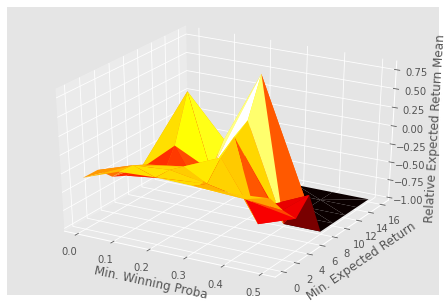

In [10]:
fig = pylab.figure()
ax = Axes3D(fig)
X = np.array([k[0] for k in res.keys()])
Y = np.array([k[1] for k in res.keys()])

Z = np.array([v['mean'] for v in res.values()])
ax.set_xlabel('Min. Winning Proba')
ax.set_ylabel('Min. Expected Return')
ax.set_zlabel('Relative Expected Return Mean')

ax.plot_trisurf(X, Y, Z, cmap='hot')

pylab.show()

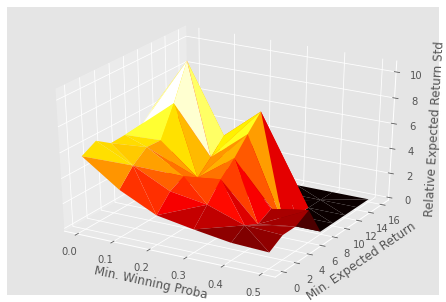

In [11]:
fig = pylab.figure()
ax = Axes3D(fig)
X = np.array([k[0] for k in res.keys()])
Y = np.array([k[1] for k in res.keys()])

Z = np.array([v['std'] for v in res.values()])

ax.plot_trisurf(X, Y, Z, cmap='hot')

ax.set_xlabel('Min. Winning Proba')
ax.set_ylabel('Min. Expected Return')
ax.set_zlabel('Relative Expected Return Std')
pylab.show()